In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
# Display setting to better visualize notebook
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',10)
pd.set_option('display.width',1000)

In [3]:
# Read Aggregated  data
df = pd.read_csv('New_features.csv')

In [4]:
df.shape

(5410, 13)

In [5]:
df.columns

Index(['Provider', 'IP_average_claim_duration', 'OP_average_claim_duration', 'PotentialFraud', 'IP_Claims_Total', 'OP_Claims_Total', 'IP_Averagedaysinhospital', 'IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt', 'IP_total_diagnosis', 'OP_total_diagnosis', 'IP_total_procedures', 'OP_total_procedures'], dtype='object')

In [6]:
df.head()

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud,IP_Claims_Total,OP_Claims_Total,IP_Averagedaysinhospital,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IP_total_diagnosis,OP_total_diagnosis,IP_total_procedures,OP_total_procedures
0,PRV51001,5.0,1.0,No,97000.0,7640.0,5.0,890.0,475.0,36.0,44.0,3.0,0.0
1,PRV51003,5.0,2.0,Yes,573000.0,32670.0,5.0,823.0,665.0,503.0,190.0,48.0,0.0
2,PRV51004,0.0,1.0,No,0.0,52170.0,0.0,454.0,601.0,0.0,385.0,0.0,0.0
3,PRV51005,0.0,1.0,Yes,0.0,280910.0,0.0,399.0,476.0,0.0,3016.0,0.0,0.0
4,PRV51007,5.0,1.0,No,19000.0,14710.0,5.0,424.0,431.0,22.0,193.0,1.0,0.0


In [7]:
X=df.drop(columns=['Provider','PotentialFraud'])

In [8]:
X.shape

(5410, 11)

In [9]:
y=df['PotentialFraud'].map({'Yes': 1, 'No': 0}) 

In [10]:
y

0       0
1       1
2       0
3       1
4       0
       ..
5405    0
5406    0
5407    0
5408    0
5409    0
Name: PotentialFraud, Length: 5410, dtype: int64

In [42]:
# comparison with and without tuning

In [43]:
# Logisttic regression
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train logistic regression without tuning
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Store results
results = pd.DataFrame({
    'Model': ['Logistic Regression (No Tuning)'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1],
    'ROC-AUC': [roc_auc]
})

print("Performance without tuning:\n", results)

Performance without tuning:
                              Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (No Tuning)  0.944547   0.797101  0.544554  0.647059  0.957621


In [44]:
# Define hyperparameter grid
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'class_weight': ['balanced', None],
        'penalty': ['l1', 'l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'class_weight': ['balanced', None],
        'penalty': ['l2']
    }
]

# Initialize model
log_reg_tuned = LogisticRegression(max_iter=1000, random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(log_reg_tuned, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_tuned = best_log_reg.predict(X_test)
y_prob_tuned = best_log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

# Store tuned results
tuned_results = pd.DataFrame({
    'Model': ['Logistic Regression (Tuned)'],
    'Accuracy': [accuracy_tuned],
    'Precision': [precision_tuned],
    'Recall': [recall_tuned],
    'F1-score': [f1_tuned],
    'ROC-AUC': [roc_auc_tuned]
})

print("\nBest Hyperparameters:", grid_search.best_params_)
print("\nPerformance with tuning:\n", tuned_results)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Hyperparameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

Performance with tuning:
                          Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (Tuned)  0.939002   0.830189  0.435644  0.571429  0.959114



Performance Comparison:
                              Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression (No Tuning)  0.944547   0.797101  0.544554  0.647059  0.957621
1      Logistic Regression (Tuned)  0.939002   0.830189  0.435644  0.571429  0.959114


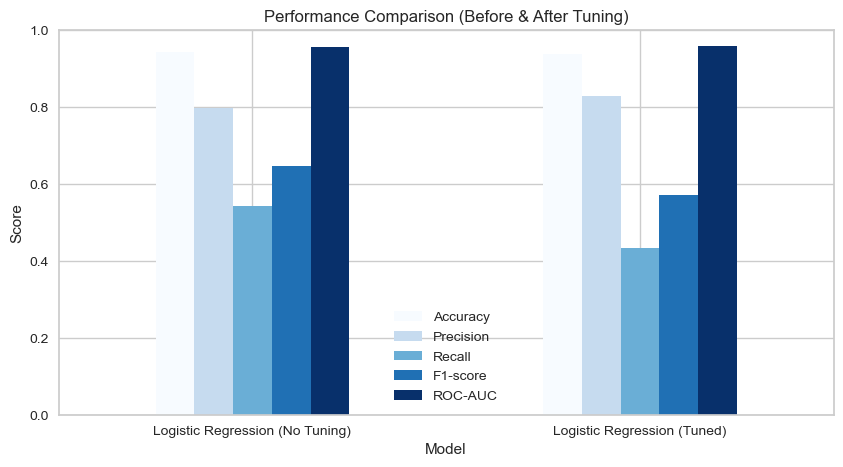

In [45]:
# Combine results
comparison = pd.concat([results, tuned_results], ignore_index=True)

# Display results
print("\nPerformance Comparison:\n", comparison)

# Visualize comparison
comparison.set_index('Model').plot(kind='bar', figsize=(10, 5), colormap='Blues', rot=0)
plt.title('Performance Comparison (Before & After Tuning)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Model by model comparison with and without tuning

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


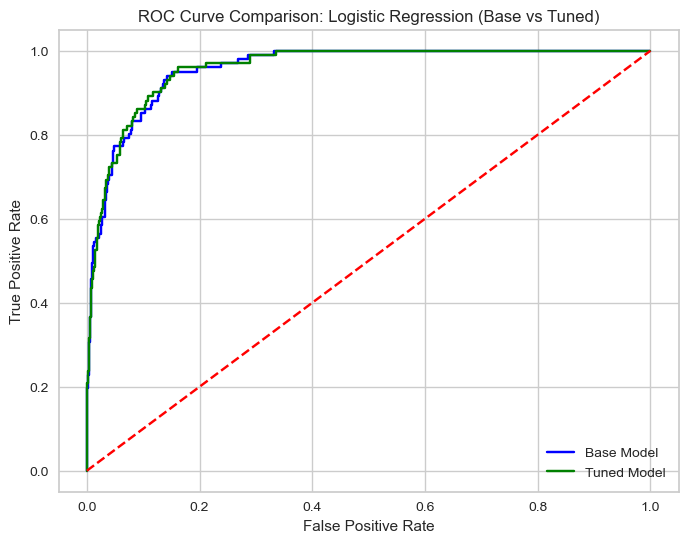

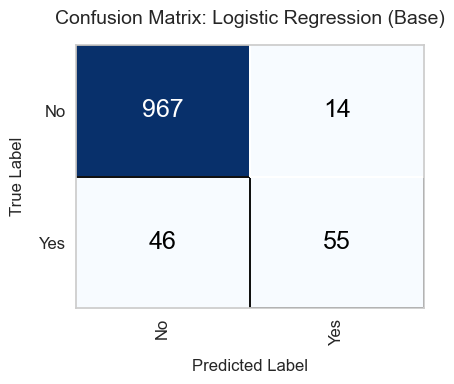

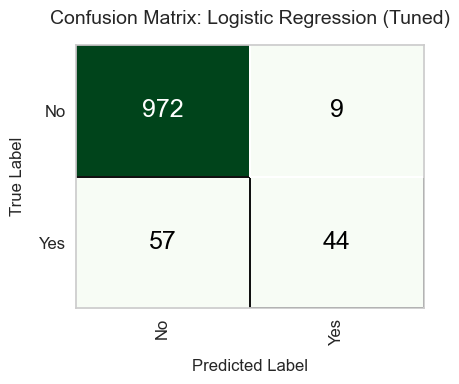

Logistic Regression (Base):
Accuracy: 0.9445
Precision: 0.7971
Recall: 0.5446
F1-score: 0.6471
ROC-AUC: 0.9576
Confusion Matrix:
 [[967  14]
 [ 46  55]]

Logistic Regression (Tuned):
Accuracy: 0.9390
Precision: 0.8302
Recall: 0.4356
F1-score: 0.5714
ROC-AUC: 0.9591
Confusion Matrix:
 [[972   9]
 [ 57  44]]


In [138]:
# Logistic Regression
# Define features and target
X = df.drop(columns=['Provider', 'PotentialFraud'])
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# ------ Logistic Regression WITHOUT Hyperparameter Tuning ------
log_reg_base = LogisticRegression(max_iter=1000, random_state=42)
log_reg_base.fit(X_train, y_train)

# Predictions
y_pred_base = log_reg_base.predict(X_test)
y_prob_base = log_reg_base.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_base = accuracy_score(y_test, y_pred_base)
precision_base = precision_score(y_test, y_pred_base)
recall_base = recall_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base)
roc_auc_base = roc_auc_score(y_test, y_prob_base)
conf_matrix_base = confusion_matrix(y_test, y_pred_base)

# ------ Logistic Regression WITH Hyperparameter Tuning ------
param_grid = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'class_weight': ['balanced', None],
        'penalty': ['l1', 'l2']
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs'],
        'class_weight': ['balanced', None],
        'penalty': ['l2']
    }
]

log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the model with best parameters
best_log_reg = grid_search.best_estimator_

# Predictions
y_pred_best = best_log_reg.predict(X_test)
y_prob_best = best_log_reg.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# ------ ROC Curve Visualization ------
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color='blue', label='Base Model')
plt.plot(fpr_best, tpr_best, color='green', label='Tuned Model')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression (Base vs Tuned)')
plt.legend(loc='lower right')
plt.show()

# ------ Confusion Matrix Visualization using Yellowbrick ------
def plot_yellowbrick_cm(model, X_train, y_train, X_test, y_test, title, cmap):
    plt.figure(figsize=(4.5, 4))  # **Reduced matrix size**
    cm = ConfusionMatrix(model, classes=['No', 'Yes'], cmap=cmap, percent=False)
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)

    # Adjust title and labels
    cm.ax.set_title(title, fontsize=14, pad=15)
    cm.ax.set_xlabel('Predicted Label', fontsize=12, labelpad=10)
    cm.ax.set_ylabel('True Label', fontsize=12, labelpad=10)
    
    # Increase font size for matrix numbers
    for text in cm.ax.texts:
        text.set_fontsize(18)  # **Larger numbers inside the matrix**
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
plot_yellowbrick_cm(log_reg_base, X_train, y_train, X_test, y_test, 'Confusion Matrix: Logistic Regression (Base)', 'Blues')
plot_yellowbrick_cm(best_log_reg, X_train, y_train, X_test, y_test, 'Confusion Matrix: Logistic Regression (Tuned)', 'Greens')

# ------ Print Performance Metrics ------
print(f'Logistic Regression (Base):')
print(f'Accuracy: {accuracy_base:.4f}')
print(f'Precision: {precision_base:.4f}')
print(f'Recall: {recall_base:.4f}')
print(f'F1-score: {f1_base:.4f}')
print(f'ROC-AUC: {roc_auc_base:.4f}')
print(f'Confusion Matrix:\n {conf_matrix_base}\n')

print(f'Logistic Regression (Tuned):')
print(f'Accuracy: {accuracy_best:.4f}')
print(f'Precision: {precision_best:.4f}')
print(f'Recall: {recall_best:.4f}')
print(f'F1-score: {f1_best:.4f}')
print(f'ROC-AUC: {roc_auc_best:.4f}')
print(f'Confusion Matrix:\n {conf_matrix_best}')